## Import Relevant packages

In [1]:
import pandas as pd
import numpy as np

# For Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from collections import Counter

# For Data Preparation
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.tree import plot_tree
import re

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

# For Evaluation of Results
from sklearn.metrics import f1_score
from sklearn import metrics

# For Product
from IPython.display import HTML
from termcolor import colored
from pyfiglet import Figlet

pd.options.mode.chained_assignment = None

## Importing of Dataset

Our dataset has 5 columns:

'v1': States whether the message is 'ham' (non-spam) or 'spam'

'v2': The content of the message

'Unnamed: 2': Contains some text, most of the cells are empty

'Unnamed: 3': Contains some text, most of the cells are empty

'Unnamed: 4': Contains some text, most of the cells are empty


Let's explore the dataset and do some preliminary cleaning.

In [2]:
df = pd.read_csv('spam.csv', encoding='iso-8859-1')
df.shape

(5572, 5)

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


At first glance, it's unclear what the 'Unnamed' columns are for. Let's take a look.

In [5]:
unnamed = df[df['Unnamed: 2'].isnull()==False]
unnamed.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


After looking at the original file, we found that these columns are actually a continuation of the main message. They were separated into different columns by the commas within the message itself. We will combine the last four columns together and rename them for better readability.

In [6]:
df['full_message'] = df['v2'].fillna('') + ' ' + df['Unnamed: 2'].fillna('')+ ' ' + df['Unnamed: 3'].fillna('')+ ' ' + df['Unnamed: 4'].fillna('')

df.rename(columns={'v1':'Category', 'full_message':'Message'}, inplace = True)
df = df.drop(['v2', 'Unnamed: 2', 'Unnamed: 3','Unnamed: 4'], axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape #new dimensions

(5572, 2)

In [8]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


It seems that not all of the messages are unique, which means that there are some duplicates. We will explore these later.

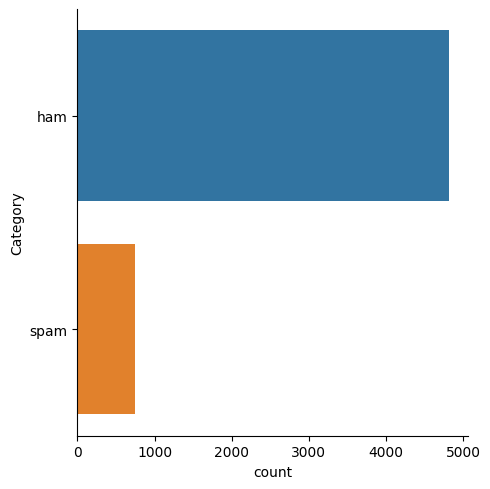

In [9]:
sns.catplot(y='Category', data=df, kind='count')

In [10]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.46: 1


As you can see, the data is quite imbalanced between non-spam and spam messages, which may affect the accuracy of any machine learning models we will use to predict the type of message. We will do some more data cleaning and then do exploratory data analysis.

## Data Cleaning

#### Changing of 'ham' and 'spam' to 0 and 1 respectively

In [11]:
df.loc[df.Category == 'ham', 'Category'] = 0
df.loc[df.Category == 'spam', 'Category'] = 1
print(df.Category.value_counts())

0    4825
1     747
Name: Category, dtype: int64


#### Removal of duplicates in SMS Messages

In [12]:
df.duplicated(subset=['Message']).value_counts()

False    5169
True      403
dtype: int64

As seen, there are 403 duplicates in the dataset and have to be removed in order to prevent skewing the data.


In [13]:
df = df.drop_duplicates(subset=['Message'], keep = 'last')
df.reset_index(drop=True, inplace=True)

print(df.shape)
print(df["Category"].value_counts())

(5169, 2)
0    4516
1     653
Name: Category, dtype: int64


In [14]:
df.describe()

,Category,Message
count,5169,5169
unique,2,5169
top,0,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


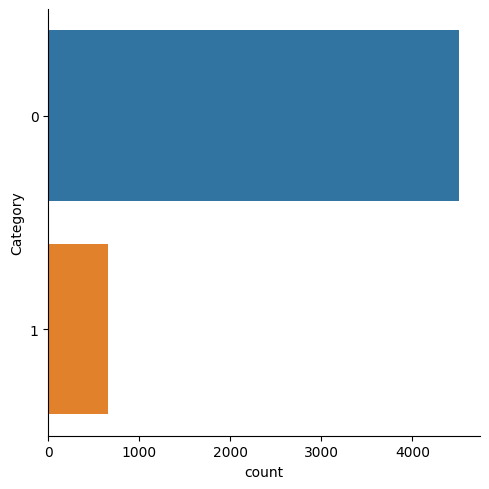

In [15]:
sns.catplot(y='Category', data=df, kind='count') #new catplot after removing the duplicates

In [16]:
countY, countX = df.Category.value_counts()
print("The ratio of non-spam to spam is %.2f: 1" % (countY/countX))

The ratio of non-spam to spam is 6.92: 1


The ratio of non-spam to spam is even higher now. This means that a majority of the duplicated messages that were removed were spam. Makes sense, since the same spam message is often sent to many people at once.

## Data Preparation

Generating Stop Words

In [17]:
stopwords = list(ENGLISH_STOP_WORDS) + list(STOPWORDS) + ['u']
print(stopwords)

['also', 'seeming', 'whom', 'we', 'should', 'mine', 'something', 'have', 'my', 'whereby', 'by', 'find', 'onto', 'hundred', 'besides', 'however', 'who', 'here', 'his', 'less', 'throughout', 'about', 'itself', 'do', 'must', 'often', 'across', 'six', 'already', 'him', 'fire', 'so', 'there', 'how', 'almost', 'had', 'anything', 'down', 'the', 'only', 'formerly', 'enough', 'whether', 'became', 'around', 'detail', 'hasnt', 'out', 'de', 'that', 'serious', 'see', 'nevertheless', 'against', 'whence', 'fifty', 'with', 'part', 'anyone', 'amount', 'former', 'from', 'cant', 'un', 'nothing', 'eg', 'afterwards', 'neither', 'otherwise', 'above', 'whither', 'over', 'nowhere', 'full', 'next', 'ours', 'ltd', 'could', 'further', 'bill', 'become', 'are', 'sincere', 'together', 'anyway', 'under', 'thereupon', 'not', 'elsewhere', 'than', 'thence', 'get', 'they', 'whenever', 'in', 'well', 'thick', 'too', 'whatever', 'noone', 'name', 'first', 'three', 'on', 'then', 'twelve', 'therefore', 'every', 'perhaps', 'tw


#### Phone Number Detection

Spam messages often contain a link or phone number which lures victims into giving away their private information. Let's see if this is reflected in our dataset.

Looking through the data, there are many instances when phone numbers were present in the message and the message was classified as spam.

In [18]:
pattern = r'\d{6,}' ## Detect messages containing a string of >=6 continuous numbers

## Create a new column to store the results of the pattern match
df['Contain_HP'] = df['Message'].apply(lambda x: bool(re.search(pattern, x)))

df.head(10)

,Category,Message,Contain_HP
0,0,"Go until jurong point, crazy.. Available only ...",False
1,0,Ok lar... Joking wif u oni...,False
2,0,U dun say so early hor... U c already then say...,False
3,0,"Nah I don't think he goes to usf, he lives aro...",False
4,1,FreeMsg Hey there darling it's been 3 week's n...,False
5,0,Even my brother is not like to speak with me. ...,False
6,0,I'm gonna be home soon and i don't want to tal...,False
7,0,I've been searching for the right words to tha...,False
8,0,I HAVE A DATE ON SUNDAY WITH WILL!!,False
9,1,"XXXMobileMovieClub: To use your credit, click ...",False


In [19]:
df['Contain_HP'].value_counts()

False    4801
True      368
Name: Contain_HP, dtype: int64